In [1]:
import dac
from dac.model.dac import EncoderBlock, DecoderBlock, ResidualUnit
from dac.nn.layers import Snake1d
from audiotools import AudioSignal
import torch
from torch import nn
import copy

In [2]:
model_path = dac.utils.download(model_type="44khz")
model = dac.DAC.load(model_path)

c:\Users\Chenk\AppData\Local\Programs\Python\Python311\Lib\site-packages\audiotools\ml\layers\base.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.l

In [3]:
model

DAC(
  (encoder): Encoder(
    (block): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): EncoderBlock(
        (block): Sequential(
          (0): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (1): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (2): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,))
              (2): Snake1d()
              

In [4]:
conv_layers = []

for idx, layer in enumerate(model.encoder.block):
    print(idx, layer)
    if isinstance(layer, nn.Conv1d):
        # print("nn.Conv1d here")
        conv_layers.append(layer)
    elif isinstance(layer, EncoderBlock):
        encoder_block_layers = layer.block
        # print("encoder block here")
        for encoder_block_layer in encoder_block_layers:
            if isinstance(encoder_block_layer, nn.Conv1d):
                # print("nn.Conv1d here")
                conv_layers.append(encoder_block_layer)
            elif isinstance(encoder_block_layer, ResidualUnit):
                residual_unit_layers = encoder_block_layer.block
                # print("residual unit here")
                # print(residual_unit_layers[0])
                # print(residual_unit_layers[1])
                # print(residual_unit_layers[2])
                # print(residual_unit_layers[3])
                
                for residual_unit_layer in residual_unit_layers:
                    if isinstance(residual_unit_layer, nn.Conv1d):
                        # print("nn.Conv1d here")
                        conv_layers.append(residual_unit_layer)
            

0 Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
1 EncoderBlock(
  (block): Sequential(
    (0): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
        (2): Snake1d()
        (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      )
    )
    (1): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
        (2): Snake1d()
        (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      )
    )
    (2): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,))
        (2): Snake1d()
        (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      )
    )
    (3): Snake1d()
    (4): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  )
)
2 EncoderBlock(
  (block): Sequential(
    (0): 

In [5]:
conv_layers = []

for idx, layer in enumerate(model.decoder.model):
    print(idx, layer)
    if isinstance(layer, nn.Conv1d):
        # print("nn.Conv1d here")
        conv_layers.append(layer)
    elif isinstance(layer, DecoderBlock):
        decoder_block_layers = layer.block
        # print("encoder block here")
        for decoder_block_layer in decoder_block_layers:
            if isinstance(decoder_block_layer, nn.Conv1d):
                # print("nn.Conv1d here")
                conv_layers.append(decoder_block_layer)
            elif isinstance(decoder_block_layer, ResidualUnit):
                residual_unit_layers = decoder_block_layer.block
                # print("residual unit here")
                for residual_unit_layer in residual_unit_layers:
                    if isinstance(residual_unit_layer, nn.Conv1d):
                        # print("nn.Conv1d here")
                        conv_layers.append(residual_unit_layer)

# conv_layers

0 Conv1d(1024, 1536, kernel_size=(7,), stride=(1,), padding=(3,))
1 DecoderBlock(
  (block): Sequential(
    (0): Snake1d()
    (1): ConvTranspose1d(1536, 768, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(768, 768, kernel_size=(7,), stride=(1,), padding=(3,))
        (2): Snake1d()
        (3): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (3): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(768, 768, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
        (2): Snake1d()
        (3): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (4): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(768, 768, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,))
        (2): Snake1d()
        (3): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
  )
)
2 DecoderBlock(
  (

In [6]:
def remove_wn(layers):
    for idx, layer in enumerate(layers):
        if isinstance(layer, (nn.Conv1d, nn.ConvTranspose1d)):
            wn_removed_layer = nn.utils.remove_weight_norm(layer)
            layers[idx] = wn_removed_layer
        elif hasattr(layer, 'block'):
            remove_wn(layer.block)

def find_conv_layers(layers, conv_layers):
    for idx, layer in enumerate(layers):
        if isinstance(layer, (nn.Conv1d, nn.ConvTranspose1d)):
            conv_layers.append(layer)
        elif hasattr(layer, 'block'):
            find_conv_layers(layer.block, conv_layers)

def find_layers(layers, conv_layers, snake_layers):
    for idx, layer in enumerate(layers):
        if isinstance(layer, (nn.Conv1d, nn.ConvTranspose1d)):
            # print(idx, layer, layer.weight.shape, layer.bias.shape)
            conv_layers.append(layer)
            if len(conv_layers) != len(snake_layers):
                snake_layers.append(None)
        elif isinstance(layer, Snake1d):
            snake_layers.append(layer)
        elif hasattr(layer, 'block'):
            find_layers(layer.block, conv_layers, snake_layers)

# [
#     [(unit1.snake1, 1), (unit1.block.conv1, 1), (unit1.block.conv2, 0), (unit2.snake1.1), ...]  # channels of activation on the residual path, they are dependent
#     [(unit1.block.conv1, 0), (unit1.block.snake2, 1), (unit1.block.conv2, 1)], # channels of the intermediate activation in the block of unit 1, they are dependent
#     []
    
#     ]

remove_wn(model.encoder.block)
remove_wn(model.decoder.model)

encoder_conv_layers = []
encoder_snake_layers = []

decoder_conv_layers = []
decoder_snake_layers = []

find_layers(model.encoder.block, encoder_conv_layers, encoder_snake_layers)
find_layers(model.decoder.model, decoder_conv_layers, decoder_snake_layers)

# encoder_conv_layers, decoder_conv_layers

In [7]:
# function to sort the channels from important to non-important
def get_input_channel_importance_conv1d(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(in_channels):
        channel_weight = weight.detach()[:, i_c]
        importance = torch.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)

# function to sort the channels from important to non-important
def get_input_channel_importance_convtranspose1d(weight):
    in_channels = weight.shape[0]
    importances = []
    # compute the importance for each input channel
    for i_c in range(in_channels):
        channel_weight = weight.detach()[i_c, :]
        importance = torch.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    # model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv from the model
    all_convs = []
    all_snakes = []
    find_layers(model.encoder.block, all_convs, all_snakes)
    find_layers(model.decoder.model, all_convs, all_snakes)
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        next_conv = all_convs[i_conv + 1]
        next_snake = all_snakes[i_conv + 1]
        # note that we always compute the importance according to input channels
        if (isinstance(next_conv, nn.ConvTranspose1d)):
            importance = get_input_channel_importance_convtranspose1d(next_conv.weight)
        else:
            importance = get_input_channel_importance_conv1d(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)
        
        # apply to the next conv input
        if (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight.copy_(torch.index_select(prev_conv.weight.detach(), 0, sort_idx))
            next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        elif (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.ConvTranspose1d)):
            prev_conv.weight.copy_(torch.index_select(prev_conv.weight.detach(), 0, sort_idx))
            next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 0, sort_idx))
        elif (isinstance(prev_conv, nn.ConvTranspose1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight.copy_(torch.index_select(prev_conv.weight.detach(), 1, sort_idx))
            next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))

        prev_conv.bias.copy_(torch.index_select(prev_conv.bias.detach(), 0, sort_idx))
        
        if next_snake:
            next_snake.alpha.data = torch.index_select(next_snake.alpha.data, 1, sort_idx)

    return model

In [8]:
from typing import Union, List

def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    return round((1 - prune_ratio) * channels)

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    # fetch all the conv from the model
    all_convs = []
    all_snakes = []
    find_layers(model.encoder.block, all_convs, all_snakes)
    find_layers(model.decoder.model, all_convs, all_snakes)
    n_conv = len(all_convs)
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    # model = copy.deepcopy(model)  # prevent overwrite
    # apply pruning. we naively keep the first k channels
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        next_snake = all_snakes[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        if (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
            next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep, :])
        elif (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.ConvTranspose1d)):
            prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
            next_conv.weight.set_(next_conv.weight.detach()[:n_keep])
        elif (isinstance(prev_conv, nn.ConvTranspose1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight.set_(prev_conv.weight.detach()[:, :n_keep, :])
            next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep, :])

        prev_conv.bias.set_(prev_conv.bias.detach()[:n_keep])

        if next_snake:
            next_snake.alpha.data = next_snake.alpha.data[:, :n_keep, :]

    return model

In [9]:
import itertools

in_channels = 3
oc = 5

# Mini test code with Conv1d -> Snake1d -> Conv1d
input_tensor = torch.randn(1, 5, 5)

conv1d_1 = nn.Conv1d(in_channels=5, out_channels=oc, kernel_size=1, padding=1, bias=False)

snake1d = Snake1d(channels=oc)
original_snake_weights = torch.rand(1, oc, 1) 
snake1d.alpha.data = original_snake_weights # Random alpha values for each channel
# print(type(snake1d.alpha), snake1d.alpha)

conv1d_2 = nn.Conv1d(in_channels=oc, out_channels=1, kernel_size=1, padding=1, bias=False)

original_conv1d_output = conv1d_1(input_tensor)
original_snake_output = snake1d(original_conv1d_output)
original_output = conv1d_2(original_snake_output)

importance = get_input_channel_importance_conv1d(conv1d_2.weight)
sort_idx = torch.argsort(importance, descending=True)
print("sort idx", sort_idx)

permutations = list(itertools.permutations(list(range(len(importance)))))

orig_weights = [conv1d_1.weight.data, conv1d_2.weight.data, snake1d.alpha.data]

for perm in permutations:
    perm = torch.tensor(perm)
    print("premutation", perm)

    conv1d_1.weight = nn.Parameter(torch.index_select(orig_weights[0], 0, perm))
    conv1d_2.weight = nn.Parameter(torch.index_select(orig_weights[1], 1, perm))
    snake1d.alpha = nn.Parameter(torch.index_select(orig_weights[2], 1, perm))
    # print(snake1d.alpha)
    # print(conv1d_1.weight)
    # print(conv1d_2.weight)

    sorted_conv1d_output = conv1d_1(input_tensor)
    sorted_snake_output = snake1d(sorted_conv1d_output)
    # if torch.allclose(original_output, sorted_output, atol=1e-6):
    #     print("\nThe outputs are the same after sorting.")
    #     print(sort_idx, perm)
    sorted_output = conv1d_2(sorted_snake_output)

    # print("Original Output:")
    # print(original_output)
    # print("\nSorted Output:")
    # print(sorted_output)

    # if torch.allclose(original_conv1d_output, sorted_conv1d_output, atol=1e-4):
    #     print(perm, "The conv1d outputs are the same after sorting.")
    #     # print(sort_idx, perm)
    # else:
    #     print(perm, "The conv1d outputs are not the same after sorting.")

    # if torch.allclose(original_snake_output, sorted_snake_output, atol=1e-4):
    #     print("\nThe snake outputs are the same after sorting.")
    #     # print(sort_idx, perm)

    if torch.allclose(original_output, sorted_output, atol=1e-4):
        print(perm, "The final outputs are the same after sorting.")
        # print(sort_idx, perm)
    else:
        print(perm, "The outputs are different after sorting.")

sort idx tensor([4, 1, 3, 2, 0])
premutation tensor([0, 1, 2, 3, 4])
tensor([0, 1, 2, 3, 4]) The final outputs are the same after sorting.
premutation tensor([0, 1, 2, 4, 3])
tensor([0, 1, 2, 4, 3]) The final outputs are the same after sorting.
premutation tensor([0, 1, 3, 2, 4])
tensor([0, 1, 3, 2, 4]) The final outputs are the same after sorting.
premutation tensor([0, 1, 3, 4, 2])
tensor([0, 1, 3, 4, 2]) The final outputs are the same after sorting.
premutation tensor([0, 1, 4, 2, 3])
tensor([0, 1, 4, 2, 3]) The final outputs are the same after sorting.
premutation tensor([0, 1, 4, 3, 2])
tensor([0, 1, 4, 3, 2]) The final outputs are the same after sorting.
premutation tensor([0, 2, 1, 3, 4])
tensor([0, 2, 1, 3, 4]) The final outputs are the same after sorting.
premutation tensor([0, 2, 1, 4, 3])
tensor([0, 2, 1, 4, 3]) The final outputs are the same after sorting.
premutation tensor([0, 2, 3, 1, 4])
tensor([0, 2, 3, 1, 4]) The final outputs are the same after sorting.
premutation t

In [10]:
model = dac.DAC.load(model_path)

print("Before pruning")
all_convs = []
find_conv_layers(model.encoder.block, all_convs)
find_conv_layers(model.decoder.model, all_convs)
for conv in all_convs:
    print("layer:", conv, "\tweight shape:", conv.weight.shape, "\tbias shape:", conv.bias.shape)


Before pruning
layer: Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,)) 	weight shape: torch.Size([64, 1, 7]) 	bias shape: torch.Size([64])
layer: Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,)) 	weight shape: torch.Size([64, 64, 7]) 	bias shape: torch.Size([64])
layer: Conv1d(64, 64, kernel_size=(1,), stride=(1,)) 	weight shape: torch.Size([64, 64, 1]) 	bias shape: torch.Size([64])
layer: Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,)) 	weight shape: torch.Size([64, 64, 7]) 	bias shape: torch.Size([64])
layer: Conv1d(64, 64, kernel_size=(1,), stride=(1,)) 	weight shape: torch.Size([64, 64, 1]) 	bias shape: torch.Size([64])
layer: Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,)) 	weight shape: torch.Size([64, 64, 7]) 	bias shape: torch.Size([64])
layer: Conv1d(64, 64, kernel_size=(1,), stride=(1,)) 	weight shape: torch.Size([64, 64, 1]) 	bias shape: torch.Size([64])
layer: Conv1d(64, 128, kernel_size=(4,), strid

In [11]:
channel_pruning_ratio = 0.3
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)

In [12]:
print("After pruning")
all_convs = []
find_conv_layers(pruned_model.encoder.block, all_convs)
find_conv_layers(pruned_model.decoder.model, all_convs)
for conv in all_convs:
    print("layer:", conv, "\tweight shape:", conv.weight.shape, "\tbias shape:", conv.bias.shape)

After pruning
layer: Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,)) 	weight shape: torch.Size([45, 1, 7]) 	bias shape: torch.Size([45])
layer: Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,)) 	weight shape: torch.Size([45, 45, 7]) 	bias shape: torch.Size([45])
layer: Conv1d(64, 64, kernel_size=(1,), stride=(1,)) 	weight shape: torch.Size([45, 45, 1]) 	bias shape: torch.Size([45])
layer: Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,)) 	weight shape: torch.Size([45, 45, 7]) 	bias shape: torch.Size([45])
layer: Conv1d(64, 64, kernel_size=(1,), stride=(1,)) 	weight shape: torch.Size([45, 45, 1]) 	bias shape: torch.Size([45])
layer: Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,)) 	weight shape: torch.Size([45, 45, 7]) 	bias shape: torch.Size([45])
layer: Conv1d(64, 64, kernel_size=(1,), stride=(1,)) 	weight shape: torch.Size([45, 45, 1]) 	bias shape: torch.Size([45])
layer: Conv1d(64, 128, kernel_size=(4,), stride

Compress and Decompress + Evaluate

In [13]:
from dac.utils import load_model
from dac import DACFile
from train import losses
from dataclasses import dataclass

ref_generator = load_model(
    model_type="44khz",
    model_bitrate="8kbps",
    tag="latest",
    load_path=model_path,
)

audio_file_path = "../samples/UrbanSound8K 7383-3-0-0.wav"

signal = AudioSignal(audio_file_path)

artifact = ref_generator.compress(signal, win_duration=5.0, verbose=False)

recons = ref_generator.decompress(artifact, verbose=False)

waveform_loss = losses.L1Loss()
stft_loss = losses.MultiScaleSTFTLoss()
mel_loss = losses.MelSpectrogramLoss()

x = signal.clone().resample(44100)
y = recons.clone().resample(44100)
mel_loss(x, y), stft_loss(x, y), waveform_loss(x, y)

c:\Users\Chenk\AppData\Local\Programs\Python\Python311\Lib\site-packages\audiotools\ml\layers\base.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.l

(tensor(1.0102), tensor(2.0919), tensor(0.0179))

In [14]:
remove_wn(ref_generator.encoder.block)
remove_wn(ref_generator.decoder.model)

artifact = ref_generator.compress(signal, win_duration=5.0, verbose=False)

recons = ref_generator.decompress(artifact, verbose=False)

waveform_loss = losses.L1Loss()
stft_loss = losses.MultiScaleSTFTLoss()
mel_loss = losses.MelSpectrogramLoss()

x = signal.clone().resample(44100)
y = recons.clone().resample(44100)
mel_loss(x, y), stft_loss(x, y), waveform_loss(x, y)

(tensor(1.0102), tensor(2.0919), tensor(0.0179))

In [15]:
sorted_model = apply_channel_sorting(ref_generator)
artifact = sorted_model.compress(signal, win_duration=5.0, verbose=False)

recons = sorted_model.decompress(artifact, verbose=False)

waveform_loss = losses.L1Loss()
stft_loss = losses.MultiScaleSTFTLoss()
mel_loss = losses.MelSpectrogramLoss()

x = signal.clone().resample(44100)
y = recons.clone().resample(44100)
mel_loss(x, y), stft_loss(x, y), waveform_loss(x, y)

# with sorting snake1d parameters: (tensor(5.9051), tensor(9.7172), tensor(0.1575))
# without sorting snake1d parameters: (tensor(5.7267), tensor(9.3324), tensor(0.1360))

# does not work because of residual nets

(tensor(5.9051), tensor(9.7172), tensor(0.1575))

In [16]:
# channel_pruning_ratio = 0.3
# pruned_model = channel_prune(sorted_model, channel_pruning_ratio)

# artifact = pruned_model.compress(signal, win_duration=5.0, verbose=False)

# recons = pruned_model.decompress(artifact, verbose=False)

# waveform_loss = losses.L1Loss()
# stft_loss = losses.MultiScaleSTFTLoss()
# mel_loss = losses.MelSpectrogramLoss()

# x = signal.clone().resample(44100)
# y = recons.clone().resample(44100)
# mel_loss(x, y), stft_loss(x, y), waveform_loss(x, y)

## Channel Pruning Only in Residual Nets

In [17]:
model_path = dac.utils.download(model_type="44khz")
model = dac.DAC.load(model_path)

c:\Users\Chenk\AppData\Local\Programs\Python\Python311\Lib\site-packages\audiotools\ml\layers\base.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.l

In [18]:
def find_residual_nets(layers, residual_nets):
    for idx, layer in enumerate(layers):
        if isinstance(layer, ResidualUnit):
            # print(idx, layer)
            residual_nets.append(layer)
        elif hasattr(layer, 'block'):
            find_residual_nets(layer.block, residual_nets)

remove_wn(model.encoder.block)
remove_wn(model.decoder.model)

encoder_residual_nets = []
decoder_residual_nets = []

find_residual_nets(model.encoder.block, encoder_residual_nets)
find_residual_nets(model.decoder.model, decoder_residual_nets)


In [19]:
@torch.no_grad()
def apply_channel_sorting_resnet_only(model):
    # fetch all the resnet from the model
    all_resnets = []
    find_residual_nets(model.encoder.block, all_resnets)
    find_residual_nets(model.decoder.model, all_resnets)
    # iterate through conv layers
    for resnet in all_resnets:
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the input dimension of the next conv (we compute importance here)
        prev_snake, prev_conv, next_snake, next_conv = resnet.block
        # note that we always compute the importance according to input channels
        if (isinstance(next_conv, nn.ConvTranspose1d)):
            importance = get_input_channel_importance_convtranspose1d(next_conv.weight)
        else:
            importance = get_input_channel_importance_conv1d(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)
        
        # apply to the next conv input
        if (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight.copy_(torch.index_select(prev_conv.weight.detach(), 0, sort_idx))
            next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        elif (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.ConvTranspose1d)):
            prev_conv.weight.copy_(torch.index_select(prev_conv.weight.detach(), 0, sort_idx))
            next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 0, sort_idx))
        elif (isinstance(prev_conv, nn.ConvTranspose1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight.copy_(torch.index_select(prev_conv.weight.detach(), 1, sort_idx))
            next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))

        prev_conv.bias.copy_(torch.index_select(prev_conv.bias.detach(), 0, sort_idx))
        
        next_snake.alpha.data = torch.index_select(next_snake.alpha.data, 1, sort_idx)

    return model
    

In [20]:
def channel_prune_model_resnet_only(model, prune_ratio):
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    # fetch all the resnet from the model
    all_resnets = []
    find_residual_nets(model.encoder.block, all_resnets)
    find_residual_nets(model.decoder.model, all_resnets)
    n_resnets = len(all_resnets)

    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_resnets
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_resnets)

    for resnet, p_ratio in zip(all_resnets, prune_ratio):
        prev_snake, prev_conv, next_snake, next_conv = resnet.block
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        if (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight = nn.Parameter(prev_conv.weight.detach()[:n_keep])
            next_conv.weight= nn.Parameter(next_conv.weight.detach()[:, :n_keep, :])
        elif (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.ConvTranspose1d)):
            prev_conv.weight = nn.Parameter(prev_conv.weight.detach()[:n_keep])
            next_conv.weight = nn.Parameter(next_conv.weight.detach()[:n_keep])
        elif (isinstance(prev_conv, nn.ConvTranspose1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight = nn.Parameter(prev_conv.weight.detach()[:, :n_keep, :])
            next_conv.weight = nn.Parameter(next_conv.weight.detach()[:, :n_keep, :])

        prev_conv.bias = nn.Parameter(prev_conv.bias.detach()[:n_keep])

        next_snake.alpha = nn.Parameter(next_snake.alpha.data.detach()[:, :n_keep, :])

        # print(prev_conv.weight.shape, nn.Parameter(next_snake.alpha.data.detach()[:n_keep]).shape, next_snake.alpha.shape)

    return model

In [21]:
from dac.utils import load_model
from dac import DACFile
from train import losses
from dataclasses import dataclass

ref_generator = load_model(
    model_type="44khz",
    model_bitrate="8kbps",
    tag="latest",
    load_path=model_path,
)

audio_file_path = "../samples/UrbanSound8K 7383-3-0-0.wav"

signal = AudioSignal(audio_file_path)
x = signal.clone().resample(44100)

waveform_loss = losses.L1Loss()
stft_loss = losses.MultiScaleSTFTLoss()
mel_loss = losses.MelSpectrogramLoss()

original_artifact = ref_generator.compress(signal, win_duration=5.0, verbose=False)
original_recons = ref_generator.decompress(original_artifact, verbose=False)
original_y = original_recons.clone().resample(44100)

remove_wn(ref_generator.encoder.block)
remove_wn(ref_generator.decoder.model)

sorted_model = apply_channel_sorting_resnet_only(ref_generator)
sorted_artifact = sorted_model.compress(signal, win_duration=5.0, verbose=False)
sorted_recons = sorted_model.decompress(sorted_artifact, verbose=False)
sorted_y = sorted_recons.clone().resample(44100)

assert(abs(mel_loss(x, original_y) - mel_loss(x, sorted_y)) < 0.01)
assert(abs(stft_loss(x, original_y) - stft_loss(x, sorted_y)) < 0.01)
assert(abs(waveform_loss(x, original_y) - waveform_loss(x, sorted_y)) < 0.01)

pruned_model = channel_prune_model_resnet_only(ref_generator, 0.3)
pruned_artifact = pruned_model.compress(signal, win_duration=5.0, verbose=False)
pruned_recons = pruned_model.decompress(pruned_artifact, verbose=False)
pruned_y = pruned_recons.clone().resample(44100)

print("Original Losses")
print("mel_loss", mel_loss(x, original_y))
print("stft_loss", stft_loss(x, original_y))
print("waveform_loss", waveform_loss(x, original_y))

print()

print("Pruned Losses")
print("mel_loss", mel_loss(x, pruned_y))
print("stft_loss", stft_loss(x, pruned_y))
print("waveform_loss", waveform_loss(x, pruned_y))

Original Losses
mel_loss tensor(1.0102)
stft_loss tensor(2.0919)
waveform_loss tensor(0.0179)

Pruned Losses
mel_loss tensor(2.9941)
stft_loss tensor(4.0910)
waveform_loss tensor(0.0376)


In [22]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def uniform_sparsity_testing(model_path, audio_file_path, channel_pruning_ratios):
    mel_losses = []
    stft_losses = []
    waveform_losses = []

    waveform_loss = losses.L1Loss()
    stft_loss = losses.MultiScaleSTFTLoss()
    mel_loss = losses.MelSpectrogramLoss()

    signal = AudioSignal(audio_file_path)
    x = signal.clone().resample(44100)

    for channel_pruning_ratio in tqdm(channel_pruning_ratios):
        model = dac.DAC.load(model_path)

        remove_wn(model.encoder.block)
        remove_wn(model.decoder.model)

        sorted_model = apply_channel_sorting_resnet_only(model)
        pruned_model = channel_prune_model_resnet_only(sorted_model, channel_pruning_ratio)

        artifact = pruned_model.compress(signal.clone(), win_duration=5.0, verbose=False)
        recons = pruned_model.decompress(artifact, verbose=False)

        y = recons.clone().resample(44100)

        mel_losses.append(mel_loss(x, y))
        stft_losses.append(stft_loss(x, y))
        waveform_losses.append(waveform_loss(x, y))

    fig, ax1 = plt.subplots()

    # Plot mel and stft losses on the primary axis
    ax1.plot(channel_pruning_ratios, mel_losses, label='Mel Loss', color='tab:blue')
    ax1.plot(channel_pruning_ratios, stft_losses, label='STFT Loss', color='tab:orange')

    ax1.set_xlabel('Channel Pruning Ratio')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a secondary axis for waveform losses
    ax2 = ax1.twinx()
    ax2.plot(channel_pruning_ratios, waveform_losses, label='Waveform Loss', color='tab:green')
    ax2.set_ylabel('Waveform Loss', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Add a legend that combines the two axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('Losses for Different (Uniform) Channel Pruning Ratios')

    plt.show()


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\Chenk\AppData\Local\Programs\Python\Python311\Lib\site-packages\audiotools\ml\layers\base.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

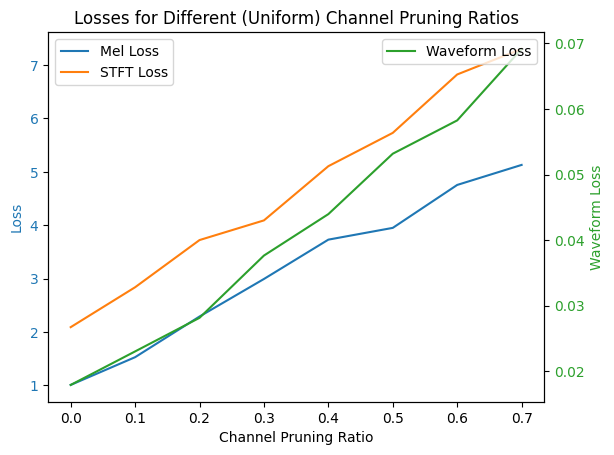

In [23]:
audio_file_path = "../samples/UrbanSound8K 7383-3-0-0.wav"
channel_pruning_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
uniform_sparsity_testing(model_path, audio_file_path, channel_pruning_ratios)